
Fitting model with 3 components...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, alpha, beta, gamma, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 300 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


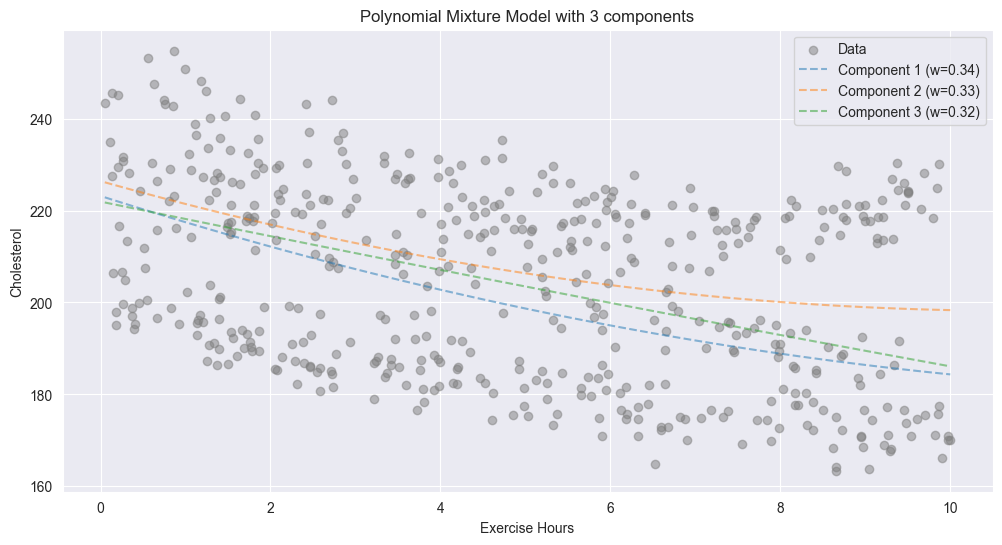


Fitting model with 4 components...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, alpha, beta, gamma, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 587 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


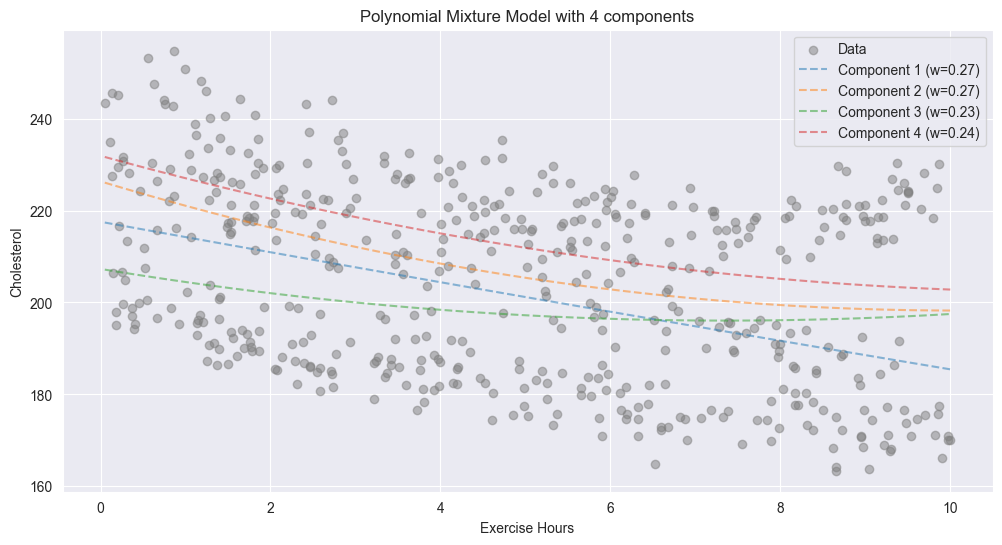


Fitting model with 5 components...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, alpha, beta, gamma, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1427 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


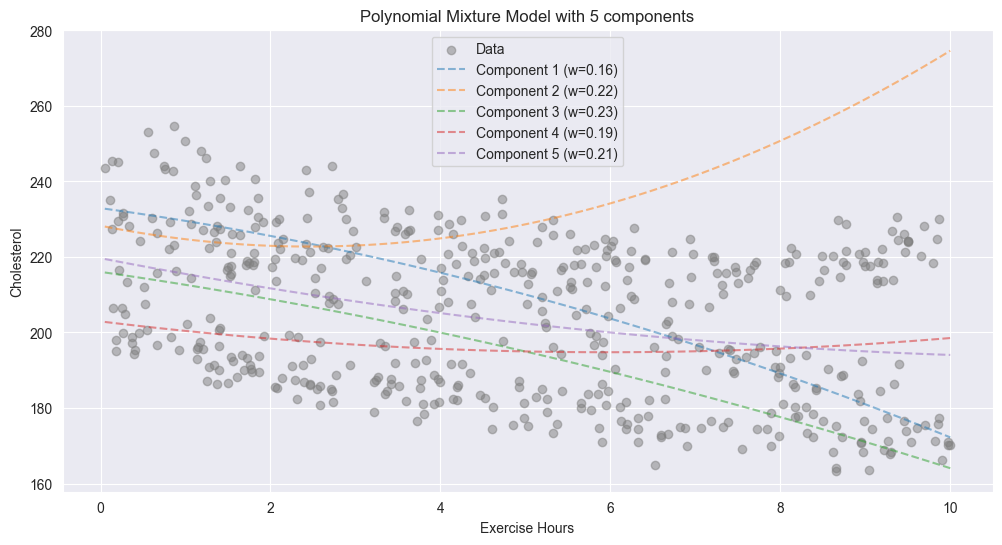


Model comparison using WAIC:


C:\Users\mihai\anaconda3\Lib\site-packages\arviz\stats\stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


         rank    elpd_waic     p_waic  elpd_diff    weight         se  \
model_4     0  4082.586091  16.369976   0.000000  0.853382  23.930881   
model_5     1  4085.839030  24.115478   3.252939  0.146618  24.243984   
model_3     2  4095.302841  20.896734  12.716750  0.000000  24.576097   

              dse  warning     scale  
model_4  0.000000    False  deviance  
model_5  4.319096     True  deviance  
model_3  4.386333    False  deviance  

Model comparison using LOO:


C:\Users\mihai\anaconda3\Lib\site-packages\arviz\stats\stats.py:1043: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\mihai\AppData\Roaming\Python\Python312\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


         rank     elpd_loo      p_loo  elpd_diff        weight         se  \
model_4     0  4082.716194  16.435027   0.000000  8.562171e-01  23.938335   
model_5     1  4085.990299  24.191113   3.274106  1.437829e-01  24.253774   
model_3     2  4095.335927  20.913277  12.619733  2.331468e-14  24.580406   

              dse  warning     scale  
model_4  0.000000    False  deviance  
model_5  4.316206    False  deviance  
model_3  4.381922    False  deviance  


<Figure size 1000x600 with 0 Axes>

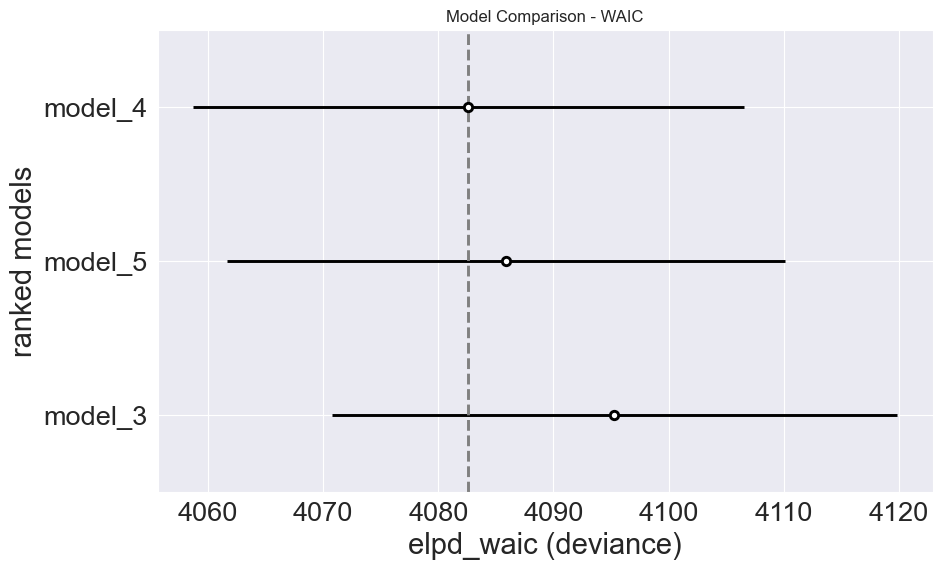

<Figure size 1000x600 with 0 Axes>

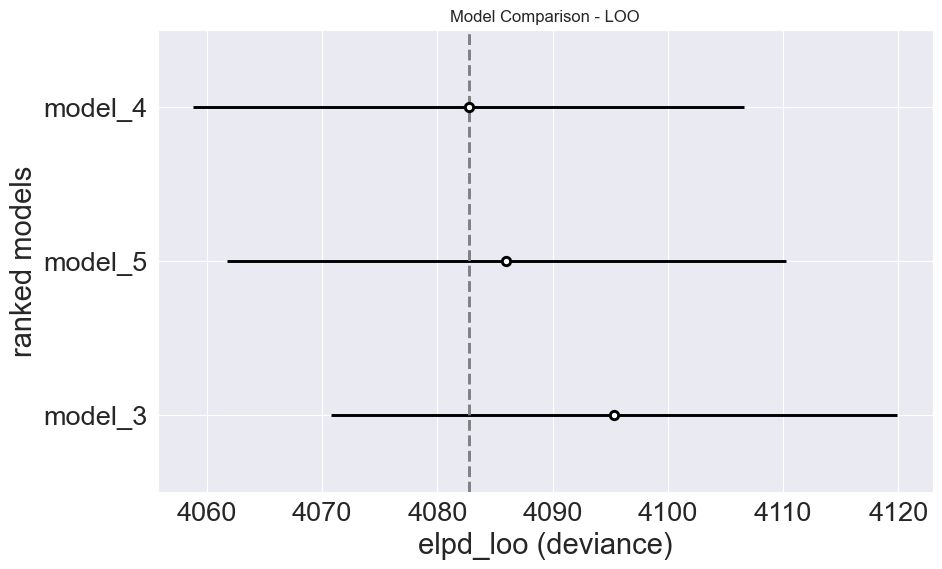

In [7]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import seaborn as sns

# Read the data
data = pd.read_csv('date_colesterol.csv')
X = data['Ore_Exercitii'].values
y = data['Colesterol'].values

def create_mixture_polynomial_model(X, y, K, random_seed=42):
    """Create and sample from a Mixture of Polynomial Regressions Model."""
    
    with pm.Model() as model:
        # Priors for mixture weights
        w = pm.Dirichlet('w', a=np.ones(K))
        
        # Priors for polynomial coefficients
        alpha = pm.Normal('alpha', mu=np.mean(y), sigma=np.std(y), shape=K)
        beta = pm.Normal('beta', mu=0, sigma=10, shape=K)
        gamma = pm.Normal('gamma', mu=0, sigma=10, shape=K)
        
        # Prior for standard deviation
        sigma = pm.HalfNormal('sigma', sigma=np.std(y), shape=K)
        
        # Components means
        means = alpha[:, None] + beta[:, None] * X + gamma[:, None] * X**2
        
        # Mixture likelihood
        y_obs = pm.NormalMixture('y_obs', 
                                w=w,
                                mu=means.T,
                                sigma=sigma,
                                observed=y)
        
        # Sample
        idata = pm.sample(2000, 
                         tune=1000,
                         random_seed=random_seed,
                         return_inferencedata=True,
                         idata_kwargs={"log_likelihood": True})
        
    return idata, model

def plot_mixture_results(X, y, idata, K, title):
    """Plot the data and fitted mixture model."""
    plt.figure(figsize=(12, 6))
    
    # Plot original data
    plt.scatter(X, y, alpha=0.5, color='gray', label='Data')
    
    # Get posterior samples
    w_samples = idata.posterior['w'].mean(dim=['chain', 'draw']).values
    alpha_samples = idata.posterior['alpha'].mean(dim=['chain', 'draw']).values
    beta_samples = idata.posterior['beta'].mean(dim=['chain', 'draw']).values
    gamma_samples = idata.posterior['gamma'].mean(dim=['chain', 'draw']).values
    
    # Plot polynomial curves for each component
    X_plot = np.linspace(X.min(), X.max(), 100)
    
    for i in range(K):
        y_component = (alpha_samples[i] + 
                      beta_samples[i] * X_plot + 
                      gamma_samples[i] * X_plot**2)
        plt.plot(X_plot, y_component, '--', alpha=0.5, 
                label=f'Component {i+1} (w={w_samples[i]:.2f})')
    
    plt.title(title)
    plt.xlabel('Exercise Hours')
    plt.ylabel('Cholesterol')
    plt.legend()
    plt.grid(True)
    plt.show()

# Fit models with different numbers of components
K_values = [3, 4, 5]
results = {}
models = {}

for K in K_values:
    print(f"\nFitting model with {K} components...")
    idata, model = create_mixture_polynomial_model(X, y, K)
    results[f'model_{K}'] = idata
    models[f'model_{K}'] = model
    
    # Plot results
    plot_mixture_results(X, y, idata, K, 
                        f'Polynomial Mixture Model with {K} components')

# Compare models using WAIC
print("\nModel comparison using WAIC:")
comparison_waic = az.compare(results, ic='waic', scale='deviance')
print(comparison_waic)

# Compare models using LOO
print("\nModel comparison using LOO:")
comparison_loo = az.compare(results, ic='loo', scale='deviance')
print(comparison_loo)

# Plot model comparisons
plt.figure(figsize=(10, 6))
az.plot_compare(comparison_waic, figsize=(10, 6))
plt.title("Model Comparison - WAIC")
plt.show()

plt.figure(figsize=(10, 6))
az.plot_compare(comparison_loo, figsize=(10, 6))
plt.title("Model Comparison - LOO")
plt.show()